# Homework 1 - An Introduction to TensorFlow
## Name: Sondre Kongsgaard
## Homework group: Anders Vagle, Brage Saether, Morten Lie

In [1]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
#from scipy.stats import multivariate_normal
#from numpy.linalg import inv

N = 2000 # Number of samples

def generate_class_0(N):
    m = [0,0]
    C = [[2, 0],[0,1]]
    return np.random.multivariate_normal(m, C, N).T

def generate_class_1(N):
    m_A = [-2,1]
    C_A = [[9.0/8, 7.0/8],[7.0/8, 9.0/8]]
    m_B = [3,2]
    C_B = [[2, 1],[1, 2]]
    
    x1 = np.zeros((2,N))
    for i in range(0, N):
        a = random.uniform(0, 1)
        if (a < 1.0/3):
            x1[:,i] = np.random.multivariate_normal(m_A, C_A, 1)
        else:
            x1[:,i] = np.random.multivariate_normal(m_B, C_B, 1)
    return x1

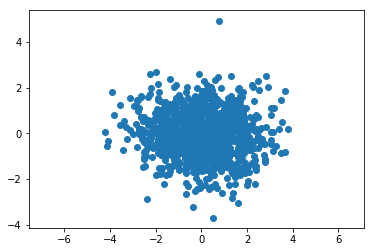

In [2]:
# Class 0, N/2 samples
x0 = generate_class_0(math.floor(N/2))
plt.scatter(x0[0],x0[1])
plt.axis('equal')
plt.show()

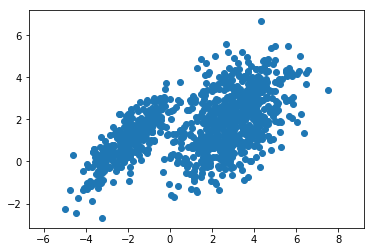

In [3]:
# Class 1, N/2 samples
x1 = generate_class_1(math.floor(N/2))
plt.scatter(x1[0], x1[1])
plt.axis('equal')
plt.show()

In [4]:
# Split the generated data into training, test and validation sets
ratio_training = 0.7
ratio_test = 0.2
ratio_validation = 0.1

x0_training = x0[:,0:math.floor(ratio_training*N/2)]
x0_test = x0[:,math.floor(ratio_training*N/2):(math.floor(ratio_training*N/2)+math.floor(ratio_test*N/2))]
x0_validation = x0[:,(math.floor(ratio_training*N/2)+math.floor(ratio_test*N/2)):]

x1_training = x1[:,0:math.floor(ratio_training*N/2)]
x1_test = x1[:,math.floor(ratio_training*N/2):(math.floor(ratio_training*N/2)+math.floor(ratio_test*N/2))]
x1_validation = x1[:,(math.floor(ratio_training*N/2)+math.floor(ratio_test*N/2)):]

# Combine the data from the two classes, and add labels
x_training = np.concatenate([x0_training, x1_training], axis=1)
x_test = np.concatenate([x0_test, x1_test], axis=1)
x_validation = np.concatenate([x0_validation, x1_validation], axis=1)

y_training = np.append(np.zeros(math.floor(ratio_training*N/2)), np.ones(math.floor(ratio_training*N/2)))
y_test = np.append(np.zeros(math.floor(ratio_test*N/2)), np.ones(math.floor(ratio_test*N/2)))
y_validation = np.append(np.zeros(math.floor(ratio_validation*N/2)), np.ones(math.floor(ratio_validation*N/2)))

# Shuffle the generated data
ind_perm_training = np.random.permutation(len(y_training))
ind_perm_test = np.random.permutation(len(y_test))
ind_perm_validation = np.random.permutation(len(y_validation))

x_training = x_training[:,ind_perm_training]
x_test = x_test[:,ind_perm_test]
x_validation = x_validation[:,ind_perm_validation]

y_training = y_training[ind_perm_training]
y_test = y_test[ind_perm_test]
y_validation = y_validation[ind_perm_validation]

# 1a) Fully connected neural network with _1_ hidden layer
## ReLU nonlinearities are used in the layers, a sigmoid at the output, and with binary cross entropy as the loss function

# 1b) Fully connected neural network with _2_ hidden layer
## ReLU nonlinearities are used in the layers, a sigmoid at the output, and with binary cross entropy as the loss function

In [5]:
# Fully connected neural network with 2 hidden layers
# ReLU nonlinearities are used in the layers, a sigmoid at the output,
# and with binary cross entropy as the loss function

# Parameters
learning_rate = 0.01
num_steps = int(N*0.7)
num_epochs = 20
batch_size = 10

# Network Parameters
n_hidden_1 = 10 # 1st layer number of neurons
n_hidden_2 = 10 # 2nd layer number of neurons
num_input = 2
num_classes = 1

# tf Graph input
X = tf.placeholder("float", [None, num_input])
Y = tf.placeholder("float", [None, num_classes])

# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([num_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, num_classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}

In [6]:
# Create model
def neural_net(x):
    # Hidden fully connected layer with 10 neurons
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    # Add ReLU nonlinearity
    layer_1 = tf.nn.relu(layer_1)
    
    # Hidden fully connected layer with 10 neurons
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    # Add ReLU nonlinearity
    layer_2 = tf.nn.relu(layer_2)
    
    # Output fully connected layer with a neuron for each class
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

In [7]:
# Construct model
logits = neural_net(X)
prediction = tf.nn.sigmoid(logits)
prediction = tf.cast(tf.greater(prediction, 1/2), tf.float32)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model (with test logits, for dropout to be disabled)
correct_pred = tf.equal(prediction, Y)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [8]:
# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    for epoch in range(1, num_epochs+1):
        for batch in range(0, num_steps, batch_size):
            batch_x = x_training[:,batch:batch+batch_size].T
            batch_y = y_training[batch:batch+batch_size].reshape([-1,1])
            
            # Run optimization op (backprop)
            sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
            
            # Calculate batch loss and accuracy
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                                 Y: batch_y})
            
            """
            print("Epoch " + str(epoch) + ", batch: " + str(batch/batch_size + 1) + \
                  ", Minibatch Loss = " + "{:.4f}".format(loss) + \
                  ", Training Accuracy = " + "{:.3f}".format(100*acc))
            """

    print("Optimization Finished!")

    # Calculate accuracy for test data
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={X: x_test.T,
                                      Y: y_test.reshape([-1,1])}))
    
    print("Validation Accuracy:", \
        sess.run(accuracy, feed_dict={X: x_validation.T,
                                      Y: y_validation.reshape([-1,1])}))

Optimization Finished!
Testing Accuracy: 0.84
Validation Accuracy: 0.865
